# Попов Д.В 6411
## Хаотические алгоритмы шифрования

In [1]:
import numpy
from matplotlib import pyplot as plt
import PIL
from PIL import Image
import numpy as np
import random
import hashlib
import re
import math
from skimage import img_as_float


def plot_img_and_hist(image, axes, bins=256):
    # Преобразование изображения в формат с плавающей запятой двойной точности
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_img.imshow(image, cmap=plt.cm.gray)

    # Display histogram
    ax_hist.hist(image.flatten(), bins=bins, histtype='step', color='black')
    ax_hist.set_xlabel('Pixel intensity', fontsize=25)
    ax_hist.tick_params(axis="x", labelsize=20)
    ax_hist.tick_params(axis="y", labelsize=20)

    return ax_img, ax_hist


def generateKey(password):
    keys = hashlib.sha256(password.encode('utf-8')).hexdigest()
    keys_list = re.findall('.{8}', keys)
    d = np.zeros((8, 1))
    for i in range(8):
        d[i] = int(keys_list[i], 16) / 2 ** 10
    x0 = (d[0] - d[1]) * d[0] % 1
    mu = d[1] % 1
    a = d[2] % np.pi
    m = d[3] % 10 // 1
    x02 = (d[0] - d[1]) * d[4] % 1
    mu2 = d[5] % 1
    a2 = d[6] % np.pi
    m2 = d[7] % 10 // 1
    print(x0, mu, a, m, x02, mu2, a2, m2)

    return x0, mu, a, int(np.around(m)), x02, mu2, a2, int(np.around(m2))


def generateChaos(x0, mu, a, m, img):
    y = np.zeros((img.shape[0] * img.shape[1], 1))
    x = np.zeros((img.shape[0] * img.shape[1], 1))
    K_1 = np.zeros((img.shape[0] * img.shape[1], 1))
    K = np.zeros((img.shape[0] * img.shape[1], 1))
    x[0] = x0[0]
    y[0] = mu[0] * np.sqrt(1 - (x0[0] ** 2))
    K_1[0] = (x[0] / y[0]) * mu[0] ** 2
    K[0] = -(math.tan(a) + K_1[0]) / (1 - K_1[0] * math.tan(a))
    for n in range(1, img.shape[0] * img.shape[1]):
        x[n] = -(2 * K[n - 1] * y[n - 1] + x[n - 1] * ((mu[0] ** 2) - (K[n - 1] ** 2))) / (
                (mu[0] ** 2) + (K[n - 1] ** 2))
        y[n] = K[n - 1] * (x[n] - x[n - 1]) + y[n - 1]
        if n < m:
            K_1[n - m] = -(x[n - 1] * (mu[0] ** 2)) / y[n - 1]

        else:
            K_1[n - m] = -(x[n - m] * mu ** 2) / y[n - 1]
            K[n] = (2 * K_1[n - m] - K[n - 1] + K[n - 1] * (K_1[n - m] ** 2)) / (
                    1 + 2 * K_1[n - m] * K[n - 1] - (K_1[n] ** 2))

    return x


def preparechaos(x, y, img):
    x = x.reshape((img.shape[0], img.shape[1]))
    y = y.reshape((img.shape[0], img.shape[1]))
    ix = np.argsort(x, axis=0, kind='stable')
    ix = np.swapaxes(ix, axis1=1, axis2=0)
    iy = np.argsort(y, axis=1, kind='stable')
    return ix, iy

def toBinMatrix(R, G, B):
    R_new = [[0] * R.shape[0] for i in range(R.shape[1])]
    G_new = [[0] * G.shape[0] for i in range(G.shape[1])]
    B_new = [[0] * B.shape[0] for i in range(B.shape[1])]
    for i in range(0, R.shape[0]):
        for j in range(0, R.shape[1]):
            R_new[i][j] = bin(round(R[i][j] * 255)).replace("0b", '')
            G_new[i][j] = bin(round(G[i][j] * 255)).replace("0b", '')
            B_new[i][j] = bin(round(B[i][j] * 255)).replace("0b", '')
            if len(R_new[i][j]) != 8:
                R_new[i][j] = str.zfill(R_new[i][j], 8)
            if len(G_new[i][j]) != 8:
                G_new[i][j] = str.zfill(G_new[i][j], 8)
            if len(B_new[i][j]) != 8:
                B_new[i][j] = str.zfill(B_new[i][j], 8)
    return R_new, G_new, B_new            

def rgbNew(R, G, B, ix, iy):
    R_new, G_new, B_new = toBinMatrix(R, G, B)
    R_n = [[0] * R.shape[0] for i in range(R.shape[1])]
    G_n = [[0] * G.shape[0] for i in range(G.shape[1])]
    B_n = [[0] * B.shape[0] for i in range(B.shape[1])]
    for i in range(0, R.shape[0]):
        for j in range(0, R.shape[1]):
            R_n[i][j] = R_new[ix[i][j]][iy[i][j]]
            G_n[i][j] = G_new[ix[i][j]][iy[i][j]] 
            B_n[i][j] = B_new[ix[i][j]][iy[i][j]]

    return R_n, G_n, B_n

def rgbOld(R, G, B, ix, iy, m):
    zashifrovany = helperDecrypte(ix, iy)
    totalR = []
    totalG = []
    totalB = []
    for i in range(len(R)):
        totalR.append([])
        totalG.append([])
        totalB.append([])
        for j in range(len(R[0])):
            inew = zashifrovany[i][j][0]
            jnew = zashifrovany[i][j][1]
            totalR[i].append(R[inew][jnew])
            totalG[i].append(G[inew][jnew])
            totalB[i].append(B[inew][jnew])
    totalR = m[:, :, 2]
    totalG = m[:, :, 1]
    totalB = m[:, :, 0]        
    return totalR, totalG, totalB
def helperDecrypte(ix, iy):
    arrr = []
    for i in range(len(ix)):
        arrr.append([])
        for j in range(len(ix[0])):
            arrr[i].append((ix[i][j], iy[i][j]))
    return arrr

def dnaEncode(Rn, Gn, Bn, rule):
    dna_matrix = np.array([["A", "00", "00", "01", "01", "10", "10", "11", "11"],
                           ["T", "11", "11", "10", "10", "01", "01", "00", "00"],
                           ["C", "01", "10", "00", "11", "00", "11", "01", "10"],
                           ["G", "10", "01", "11", "00", "11", "00", "10", "01"]])
    R_dna = [["" for j in range(len(Rn))] for i in range(len(Rn[0]))]
    G_dna = [["" for j in range(len(Gn))] for i in range(len(Gn[0]))]
    B_dna = [["" for j in range(len(Bn))] for i in range(len(Bn[0]))]
    for i in range(0, len(Rn)):
        for j in range(0, len(Rn[i])):
            for k in range(0, len(Rn[i][j]), 2):
                for l in range(4):
                    if Rn[i][j][k:k + 2] == dna_matrix[l][rule]:
                        R_dna[i][j] += dna_matrix[l][0]
                    if Gn[i][j][k:k + 2] == dna_matrix[l][rule]:
                        G_dna[i][j] += dna_matrix[l][0]
                    if Bn[i][j][k:k + 2] == dna_matrix[l][rule]:
                        B_dna[i][j] += dna_matrix[l][0]
    return R_dna, G_dna, B_dna


def convert(x, y, z, img):
    xn = np.zeros((x.shape[0], 1))
    yn = np.zeros((y.shape[0], 1))
    zn = np.zeros((z.shape[0], 1))
    for i in range(img.shape[0] * img.shape[1]):
        xn[i] = numpy.around((abs(x[i]) * 1000) % 256)
        yn[i] = numpy.around((abs(y[i]) * 500) % 256)
        zn[i] = numpy.around((abs(z[i]) * 1000) % 256)
    xn = xn.reshape((img.shape[0], img.shape[1]))
    yn = yn.reshape((img.shape[0], img.shape[1]))
    zn = zn.reshape((img.shape[0], img.shape[1]))
    x_new, y_new, z_new = toBinMatrix(xn, yn, zn)
    return x_new, y_new, z_new


def dnaXOR(dna_1, dna_2):
    res = [["" for j in range(len(dna_1))] for i in range(len(dna_1[0]))]
    for i in range(0, len(dna_1)):
        for j in range(0, len(dna_1[i])):
            for k in range(0, len(dna_1[i][j])):
                if dna_1[i][j][k] == dna_2[i][j][k]:
                    res[i][j] += 'A'
                    continue
                else:
                    if dna_1[i][j][k] == 'A':
                        res[i][j] += dna_2[i][j][k]
                        continue
                    if dna_2[i][j][k] == 'A':
                        res[i][j] += dna_1[i][j][k]
                        continue
                    if (dna_2[i][j][k] == 'G' and dna_1[i][j][k] == 'C') or (
                            dna_2[i][j][k] == 'C' and dna_1[i][j][k] == 'G'):
                        res[i][j] += 'T'
                        continue
                    if (dna_2[i][j][k] == 'G' and dna_1[i][j][k] == 'T') or (
                            dna_2[i][j][k] == 'T' and dna_1[i][j][k] == 'G'):
                        res[i][j] += 'C'
                        continue
                    if (dna_2[i][j][k] == 'T' and dna_1[i][j][k] == 'C') or (
                            dna_2[i][j][k] == 'C' and dna_1[i][j][k] == 'T'):
                        res[i][j] += 'G'
                        continue
    return res


def dnaDecode(Rn, Gn, Bn, rule):
    dna_matrix = np.array([["A", "00", "00", "01", "01", "10", "10", "11", "11"],
                           ["T", "11", "11", "10", "10", "01", "01", "00", "00"],
                           ["C", "01", "10", "00", "11", "00", "11", "01", "10"],
                           ["G", "10", "01", "11", "00", "11", "00", "10", "01"]])

    R_encrypt = [["" for j in range(len(Rn))] for i in range(len(Rn[0]))]
    G_encrypt = [["" for j in range(len(Gn))] for i in range(len(Gn[0]))]
    B_encrypt = [["" for j in range(len(Bn))] for i in range(len(Bn[0]))]
    for i in range(0, len(Rn)):
        for j in range(0, len(Rn[i])):
            for k in range(0, len(Rn[i][j])):
                for l in range(4):
                    if Rn[i][j][k] == dna_matrix[l][0]:
                        R_encrypt[i][j] += dna_matrix[l][rule]
                    if Gn[i][j][k] == dna_matrix[l][0]:
                        G_encrypt[i][j] += dna_matrix[l][rule]
                    if Bn[i][j][k] == dna_matrix[l][0]:
                        B_encrypt[i][j] += dna_matrix[l][rule]
    for i in range(0, len(Rn)):
        for j in range(0, len(Rn[i])):
            R_encrypt[i][j] = int(R_encrypt[i][j], 2) / 255
            G_encrypt[i][j] = int(G_encrypt[i][j], 2) / 255
            B_encrypt[i][j] = int(B_encrypt[i][j], 2) / 255

    return R_encrypt, G_encrypt, B_encrypt


def normalize():
    img_1 = Image.open('Lenna.png')
    cnt = img_1.size[0]
    for i in range(0, 32):
        if cnt % 32 == 0:
            break
        cnt += 1
    img_1 = img_1.resize((cnt, cnt), PIL.Image.ANTIALIAS)
    img_1.save("Lenna.png")

# #Исходное изображение его гистограмма

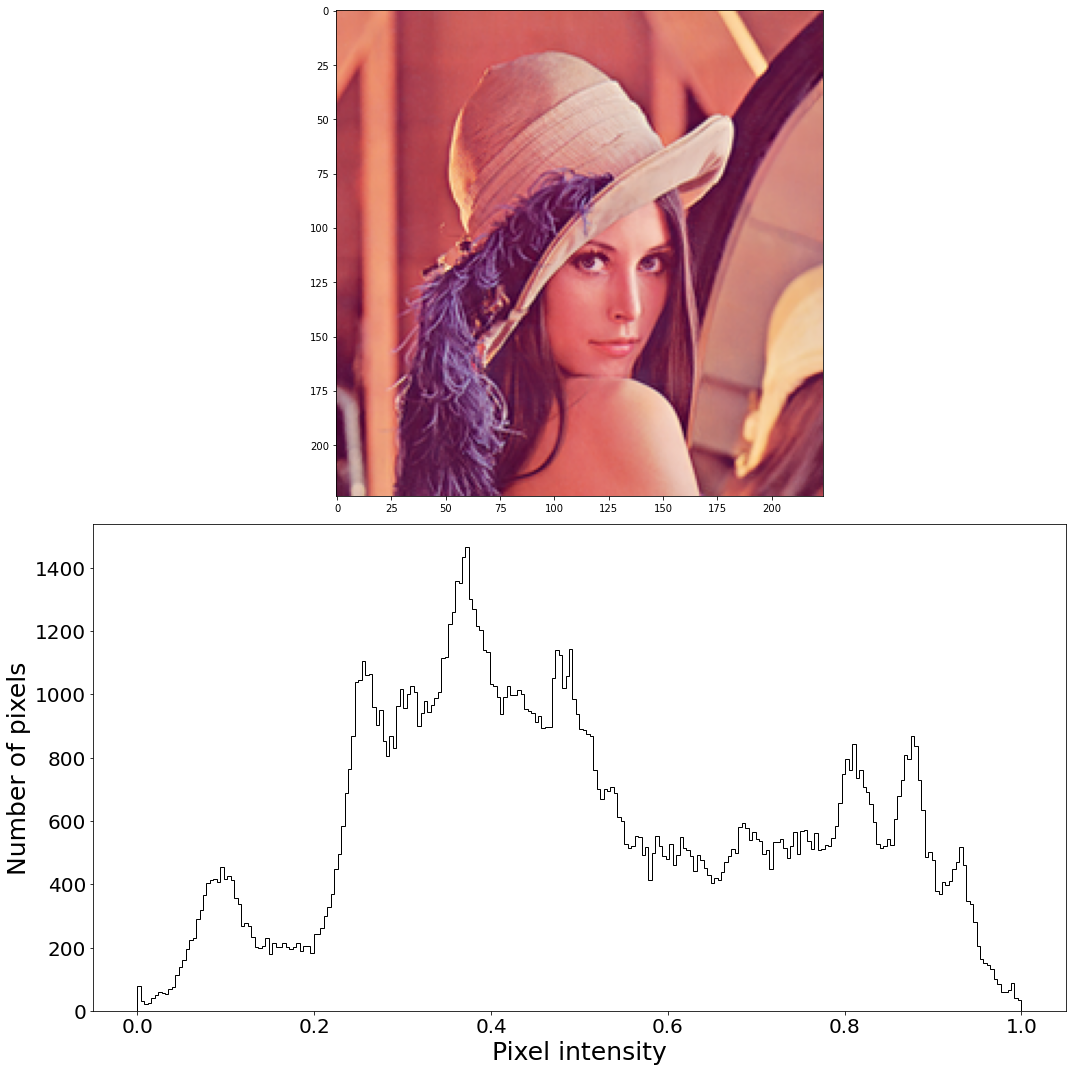

In [2]:
normalize()
img = plt.imread("Lenna.png")

fig = plt.figure(figsize=(15, 15))
axes = np.zeros((2, 1), dtype=object)
axes[0, 0] = fig.add_subplot(211)
axes[1, 0] = fig.add_subplot(212)

ax_img, ax_hist = plot_img_and_hist(img, axes[:, 0])
ax_hist.set_ylabel('Number of pixels', fontsize=25)

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

# #Зашифрованное изображение и его гистограмма:

[0.51660156] [0.40234375] [1.75551623] [2.] [0.82080078] [0.17871094] [0.06509715] [3.]


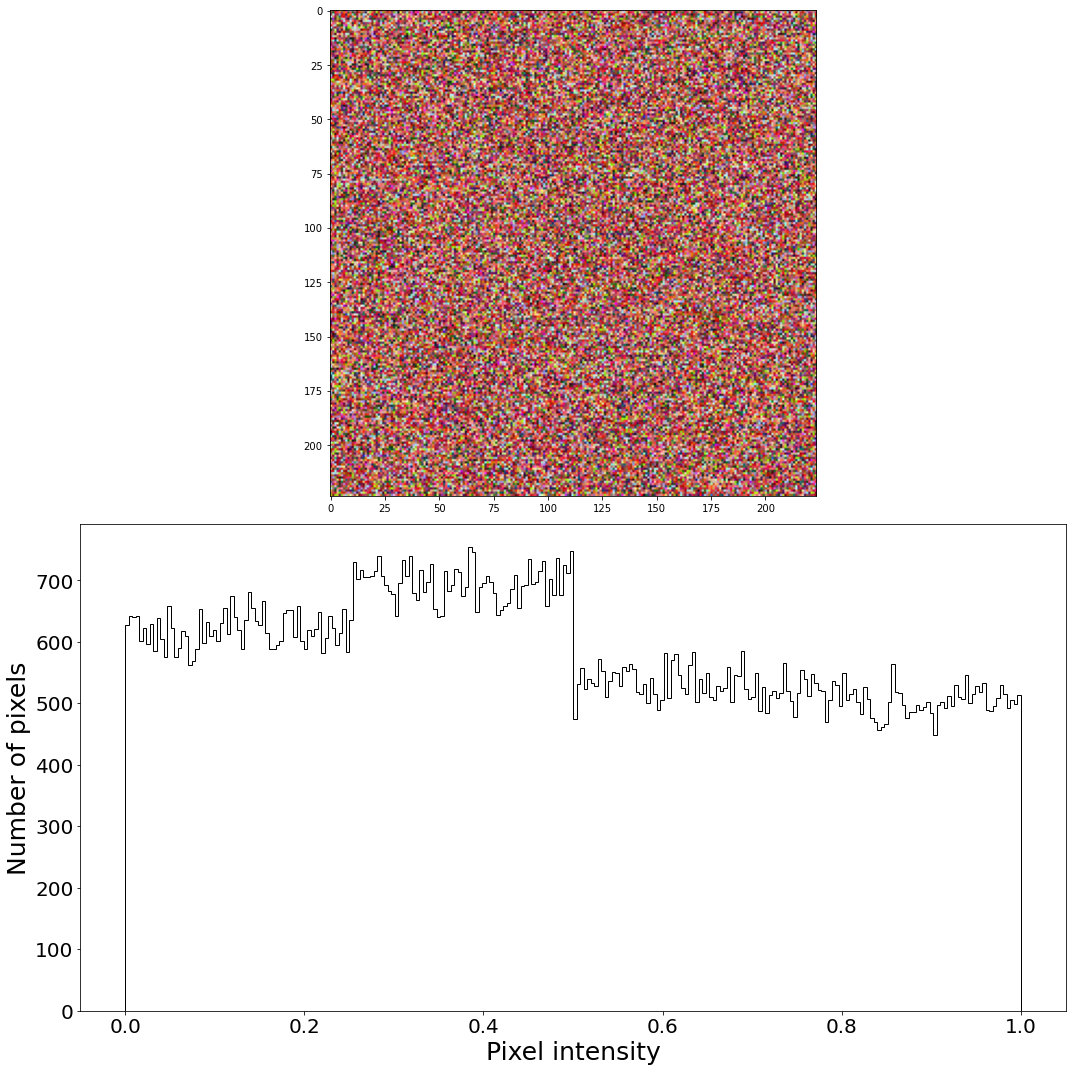

In [4]:
x0, mu, a, m, x02, mu2, a2, m2 = generateKey("Popov")
R, G, B = img[:, :, 2], img[:, :, 1], img[:, :, 0]
x = generateChaos(x0, mu, a, m, img)
y = generateChaos(x0, mu, a, m, img)
ix, iy = preparechaos(x, y, img)
Rn, Gn, Bn = rgbNew(R, G, B, ix, iy)
rule = random.randint(1, 8)
R_dna, G_dna, B_dna = dnaEncode(Rn, Gn, Bn, rule)
xn = generateChaos(x02, mu2, a2, m2, img)
yn = generateChaos(x02, mu2, a2, m2, img)
zn = generateChaos(x02, mu2, a2, m2, img)
xn, yn, zn = convert(xn, yn, zn, img)
x_dna, y_dna, z_dna = dnaEncode(xn, yn, zn, rule)
R_encrypted = dnaXOR(R_dna, x_dna)
G_encrypted = dnaXOR(G_dna, y_dna)
B_encrypted = dnaXOR(B_dna, z_dna)
img_encrypted = np.array(img)
img_encrypted[:, :, 2], img_encrypted[:, :, 1], img_encrypted[:, :, 0] = dnaDecode(R_encrypted, G_encrypted,
                                                                                   B_encrypted, rule)
fig = plt.figure(figsize=(15, 15))
axes = np.zeros((2, 1), dtype=object)
axes[0, 0] = fig.add_subplot(211)
axes[1, 0] = fig.add_subplot(212)

ax_img, ax_hist = plot_img_and_hist(img_encrypted, axes[:, 0])
ax_hist.set_ylabel('Number of pixels', fontsize=25)

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

## Дешифрованное изображение и его гистограмма

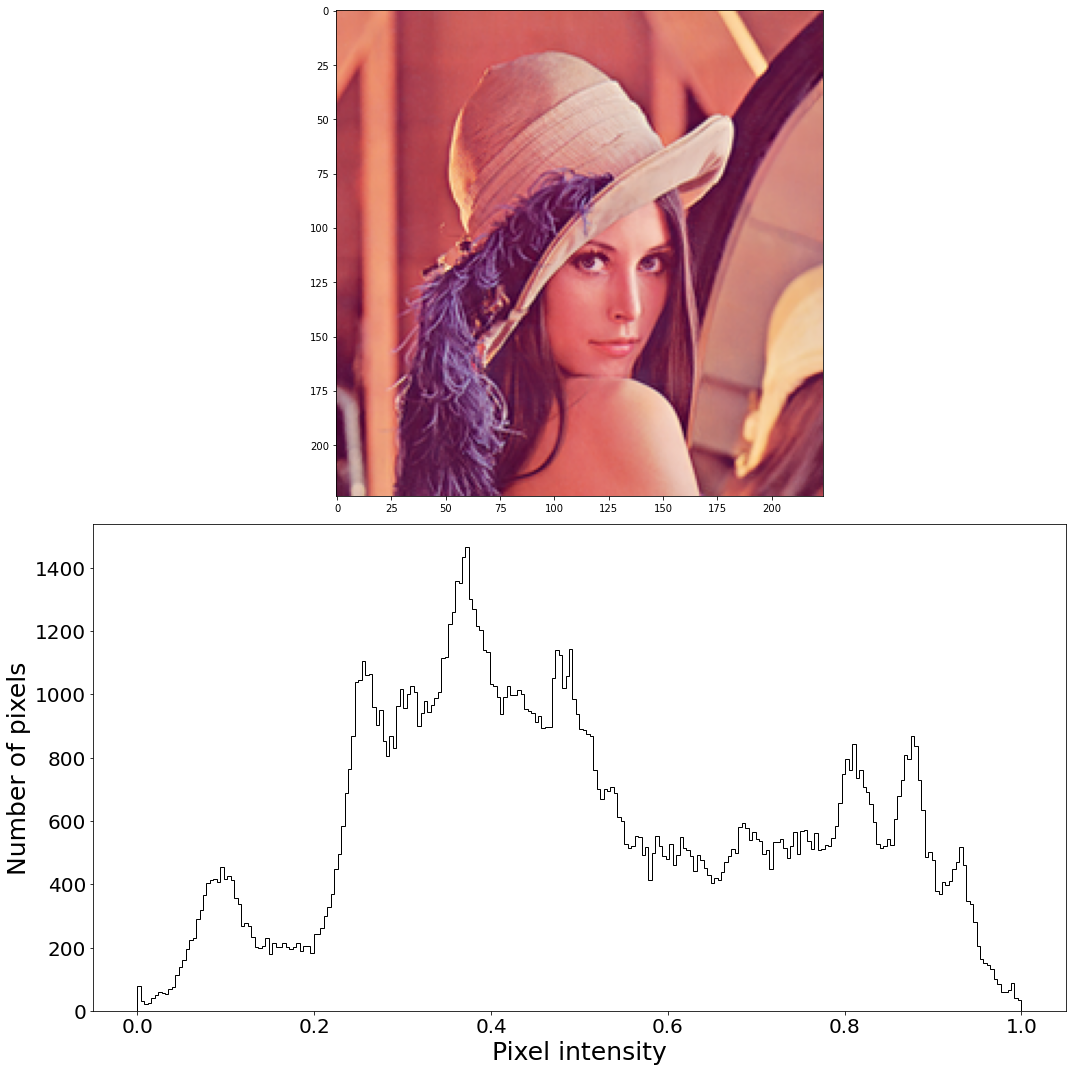

In [84]:
R_e, G_e, B_e = img_encrypted[:, :, 2], img_encrypted[:, :, 1], img_encrypted[:, :, 0]
R_e, G_e, B_e = toBinMatrix(R_e, G_e, B_e)
R_dna, G_dna, B_dna = dnaEncode(R_e, G_e, B_e, rule)
xn = generateChaos(x02, mu2, a2, m2, img)
yn = xn
zn = xn
xn, yn, zn = convert(xn, yn, zn, img)
x_dna, y_dna, z_dna = dnaEncode(xn, yn, zn, rule)
R_d = dnaXOR(R_dna, x_dna)
G_d = dnaXOR(G_dna, y_dna)
B_d = dnaXOR(B_dna, z_dna)
x = generateChaos(x0, mu, a, m, img)
y = generateChaos(x0, mu, a, m, img)
R_decrypted, G_decrypted, B_decrypted = dnaDecode(R_d, G_d, B_d, rule)
ix, iy = preparechaos(x, y, img)
R_decrypted, G_decrypted, B_decrypted = rgbOld(R_decrypted, G_decrypted, B_decrypted, ix, iy, img)
img_decrypted = np.array(img)
img_decrypted[:, :, 2], img_decrypted[:, :, 1], img_decrypted[:, :, 0] = R_decrypted, G_decrypted, B_decrypted

fig = plt.figure(figsize=(15, 15))
axes = np.zeros((2, 1), dtype=object)
axes[0, 0] = fig.add_subplot(211)
axes[1, 0] = fig.add_subplot(212)

ax_img, ax_hist = plot_img_and_hist(img_decrypted, axes[:, 0])
ax_hist.set_ylabel('Number of pixels', fontsize=25)

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()